## Project imports

In [1]:
"tensorflow 2.9.1"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
from dotenv import load_dotenv
from pip import main
import seaborn as sns 
# Libraries for TensorFlow
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Input, Conv2D, Dense, MaxPooling2D, Flatten, BatchNormalization,  Dropout, Concatenate
from tensorflow import keras

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.ops.numpy_ops import np_config

np_config.enable_numpy_behavior()

## Config logs and files

In [2]:
load_dotenv()
BASE_PATH = os.environ.get("BASE_PATH")
SAVE_PATH = os.path.join(BASE_PATH, 'models_save')


In [3]:
def make_folder(path, base_path = BASE_PATH):
  dir = os.path.join(base_path, path)
  if not os.path.exists(dir):
    os.makedirs(dir)
  return dir 

In [4]:
plt.rcParams['figure.figsize'] = [15, 5]
base_log_dir = "logs"
sns.set_style("darkgrid")
make_folder(base_log_dir)


'.\\logs'

## Define block layers and callback

In [5]:
# Define a callback funcion
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=30,
    verbose=1,
    mode='min',
    baseline=None,
    restore_best_weights=True
)

# Define Block
def MK_block(input_):
    out_1_3 = Conv2D(48,kernel_size=(3,3),activation="relu",padding="same")(input_)
    out_1_5 = Conv2D(24,kernel_size=(5,5),activation="relu",padding="same")(input_)
    out_1_7 = Conv2D(12,kernel_size=(7,7),activation="relu",padding="same")(input_)

    out_1_3_5 = Concatenate()([input_,out_1_3,out_1_5])
    out_1_5_7 = Concatenate()([input_,out_1_3,out_1_5,out_1_7])

    out_1_b_3 = BatchNormalization()(out_1_3)
    out_1_b_3_5 = BatchNormalization()(out_1_3_5)
    out_1_b_5_7 = BatchNormalization()(out_1_5_7)

    out_2_3 = Conv2D(48,kernel_size=(3,3),activation="relu",padding="same")(out_1_b_3)
    out_2_5_2 = Conv2D(24,kernel_size=(5,5),activation="relu",padding="same")(out_1_b_3)
    out_2_3 = Concatenate()([input_,out_2_3,out_2_5_2,out_1_b_3])

    out_2_5 = Conv2D(36,kernel_size=(5,5),activation="relu",padding="same")(out_1_b_3_5)
    out_2_7 = Conv2D(18,kernel_size=(7,7),activation="relu",padding="same")(out_1_b_5_7)

    out_3_5_7 = Concatenate()([input_,out_2_5,out_2_7])
    out_3_b_5_7 = BatchNormalization()(out_3_5_7)
    out_3_b_3 = BatchNormalization()(out_2_3)

    out_4_3 = Conv2D(72,kernel_size=(3,3),activation="relu",padding="same")(out_3_b_5_7)
    out_4_b_3 = BatchNormalization()(out_4_3)

    out  = Concatenate()([input_,out_3_b_3,out_1_b_3,out_1_b_3_5,out_1_b_5_7,out_3_b_5_7,out_4_b_3])
    out = Conv2D(24,kernel_size=(1,1), activation="relu",padding="same")(out)
    out = BatchNormalization()(out)
    out = MaxPooling2D(pool_size=(2,2))(out)

    return out

## Build model

Preexisting model for comparison

In [6]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
def inception_model():
    # create the base pre-trained model
    base_model = InceptionV3(weights='imagenet', input_shape= (75,75, 3),  include_top=False)

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    # and a logistic layer -- let's say we have 10 classes
    predictions = Dense(10, activation='softmax')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False

    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])   
    return model 

block based model

In [7]:
# Define Overall Model
def build_model(shape=1, block_model = True):

    input_ = Input(shape=(28,28,shape))
    input_ = tf.keras.layers.Rescaling(1./255)(input_)
    if block_model == False:
        return inception_model()
    out_d = MK_block(input_)
    out_d = MK_block(out_d)
    out_d = MK_block(out_d)

    flat = Flatten()(out_d)
    dr = 0.3

    out_d = Dense(256,activation="relu")(flat)
    out_d = Dropout(dr)(out_d)
    out_d = Dense(128,activation="relu")(out_d)
    out_d = Dropout(dr)(out_d)
    out_d = Dense(128,activation="relu")(out_d)
    out_d = Dropout(dr)(out_d)

    out_d = Dense(64,activation="relu")(out_d)
    out_d = Dropout(dr)(out_d)

    out_d = Dense(10,activation="softmax")(out_d)

    model = keras.Model(inputs=input_,outputs=out_d)

    keras.utils.plot_model(model,expand_nested=True,show_shapes=True, to_file="model.png",show_dtype=True,show_layer_activations=True)
    plt.show()
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    print("Model built successfully.")
    return model

## Train model

In [8]:
def train_model(model,dir, x_train, y_train,x_test, y_test):
    folder = make_folder(dir, SAVE_PATH)
    # Changed epochs from 1000 to 10, because it takes 1 hour per epoch 
    History = model.fit(x_train,y_train,validation_data=(x_test,y_test),batch_size=128,epochs=10,verbose=1, callbacks=[callback])

    # Export results as CSV for ploting
    hist_df = pd.DataFrame(History.history)
    
    hist_csv_file = os.path.join(folder, 'history.csv')
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        
    # Save model
    model.save(f'{folder}.h5')

## Select and load datasets

In [9]:
valid_proportion = 0.2 

In [10]:
def show_dataset(x, y):
    #class_names = dataset.class_names
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(x[i].astype("uint8"))
        # plt.title(y[i])
        plt.axis("off")

In [11]:


def load_data(option, block_model = True):
    shape = 28 if block_model else 75
    if option == 'fashion':
        # Load Fashion-MNIST dataset
        (x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
         # Make sure images have shape (28, 28, 1)
        x_train_full = np.expand_dims(x_train_full, -1)
        x_test = np.expand_dims(x_test, -1)

        if not block_model:
            # reshape to (75,  75, 3)
            x_train_full = tf.image.resize(x_train_full, [shape,shape])
            x_test = tf.image.resize(x_test, [shape,shape])
            x_train_full = tf.image.grayscale_to_rgb(x_train_full)
            x_test = tf.image.grayscale_to_rgb(x_test)


    elif option == 'digit':
        # Load MNIST-digit
        (x_train_full, y_train_full), (x_test, y_test) = keras.datasets.mnist.load_data()
         # Make sure images have shape (28, 28, 1)
        x_train_full = np.expand_dims(x_train_full, -1)
        x_test = np.expand_dims(x_test, -1)
        if not block_model:
            # reshape to (75,  75, 3)
            x_train_full = tf.image.resize(x_train_full, [shape,shape])
            x_test = tf.image.resize(x_test, [shape,shape])
            x_train_full = tf.image.grayscale_to_rgb(x_train_full)
            x_test = tf.image.grayscale_to_rgb(x_test)


    elif option == 'cifar10':
        # Load CIFAR-10 small images
        (x_train_full, y_train_full), (x_test, y_test) = keras.datasets.cifar10.load_data()
         # Make sure images have shape (28, 28, 1)
        x_train_full = tf.image.resize(x_train_full, [shape,shape])
        x_test = tf.image.resize(x_test, [shape,shape])
 
    else:
        pass
    # convert class vectors to binary class matrices
    y_train_full = keras.utils.to_categorical(y_train_full, 10)
    y_test = keras.utils.to_categorical(y_test, 10)
    x_valid, x_train = np.split(x_train_full, [int(valid_proportion * len(x_train_full))]  )
    y_valid, y_train = np.split(y_train_full, [int(valid_proportion * len(y_train_full))]  )   
    show_dataset(x_train, y_train)
    print("x_train shape:", x_train.shape)
    print(x_train.shape[0], "train samples")
    print(x_test.shape[0], "test samples")
    print(x_valid.shape[0], "validation samples")
    return x_train, y_train, x_valid, y_valid, x_test, y_test



select dataset for  training:
 
    1) digit

    2) fashion

    3) cifar10


select model type:

    true) block based
    
    false) inception v3



In [12]:
options = {
    '1':['digit',1],
    '2':['fashion', 1],
    '3':['cifar10', 3]
}
chosen = '3'
block_model = True 
load_model = True

x_train shape: (40000, 28, 28, 3)
40000 train samples
10000 test samples
10000 validation samples


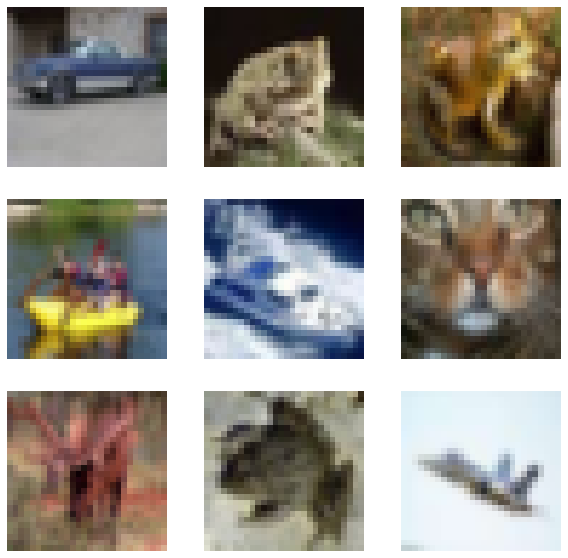

In [13]:
dataset, shape = options[chosen]
dataset_model = f"{dataset}-{'block' if block_model else 'inception'}"

x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(dataset, block_model)

# Pre Processing
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_valid = x_valid.astype("float32") / 255

if load_model:
    model = keras.models.load_model(os.path.join(SAVE_PATH, f'{dataset_model}.h5'))
else:
    model = build_model(shape, block_model)


In [14]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 conv2d_497 (Conv2D)            (None, 28, 28, 48)   1344        ['input_22[0][0]']               
                                                                                                  
 conv2d_498 (Conv2D)            (None, 28, 28, 24)   1824        ['input_22[0][0]']               
                                                                                                  
 conv2d_499 (Conv2D)            (None, 28, 28, 12)   1776        ['input_22[0][0]']               
                                                                                            

In [15]:
if not load_model:
    train_model(model, dataset_model,  x_train, y_train, x_valid, y_valid)


In [16]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 125s 396ms/step - loss: 0.8614 - accuracy: 0.7397


[0.8614205121994019, 0.7397000193595886]